<a id='home'></a>
### purpose 

- I need to clip future climate (or common garden climate) using species range shapefiles to ease computational burdens of gradient forests
- However, not all of my populations fall within the canonical range shapefile (meaning I can't pull data for my pops from a range-cut climate/GIS layer)
- I therefore need to update the shapefiles for Douglas-fir, Western larch, and jack pine so that all of our samples are within the shapefile polygons. These pops are usually just outside of the polygons provided by USGS. I simply draw a small polygon around these pops, dissolve any polygons that overlap with those in the canonical shapefile, and then save the new shapefile
- I also need elevation data across the range of our species for training in gradient forest (climate data is separated from elevation), so I save this along with each of the other climate variables into a single dataframe cut for each species.

### outline
[coastal and interior Douglas-fir](#combined)

[coastal Douglas-fir](#coastal)

[interior Douglas-fir](#interior)

[jack pine](#jack)

[western larch](#western)

In [1]:
from pythonimports import *
import xarray as xr
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
import fiona
import shapely

DIR = '/data/projects/pool_seq/environemental_data/netCDF_files/NA_NORM_1961-1990'

latest_commit()
sinfo(html=True)

##################################################################
Current commit of pythonimports:
commit 41e78e807c8c7029ce9697b7a2601c21e6d6ce3b  
Author: Brandon <brandon.lind@ubc.ca>  
Date:   Wed Jun 23 12:08:44 2021 -0600
Today:	June 24, 2021 - 11:49:27
python version: 3.8.5
##################################################################


In [2]:
def clip_and_retrieve(shapefile, envdata, latcol='LAT', loncol='LONG'):
    """Clip elevation data by `shapefile`, return data for lat/long in `envdata`.
    
    Notes
    -----
    prints the number of pops outside of the given shapefile.
    """
    # clip elevation data to the range in the shapefile
    shp = gpd.read_file(shapefile, crs=ccrs.PlateCarree())
    clipped = dataset.rio.clip(shp.geometry.apply(mapping), shp.crs, drop=False)
    print('clipped dataset:')
    display(clipped)
    # pull offset values directly from the shapefile to ID the pops outside of the shapefile
    target_lat = xr.DataArray(envdata[latcol], dims='points')
    target_lon = xr.DataArray(envdata[loncol], dims='points')
    elevdata = clipped['Band1'].sel(lon=target_lon, lat=target_lat, method='nearest').to_dataframe()
    elevdata.index = envdata['our_id'].tolist()
    
    summ = elevdata['Band1'].isnull().sum()
    perc = round(summ / nrow(elevdata), 4)*100
    print(f'There are {summ} null values out of {nrow(elevdata)} rows in elevdata ({perc}%).')
    return elevdata,shp

def get_elev_data():
    """Retrieve elevational data"""
    # read in elevation file
    elev_nc = op.join(op.dirname(DIR), 'NA_Reference_files/ClimateNA_DEM_WGS84.nc')
    assert op.exists(elev_nc)
    dataset = xr.open_dataset(elev_nc, decode_times=False)
    dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    dataset.rio.write_crs("epsg:4326", inplace=True)
    return dataset

def create_pop_polygons(buffer_size=0.1, loncol='LONG', latcol='LAT'):
    """For each pop not in the previous shapefile, draw a polygon around the pops' lat/long."""
    outside = envdata.loc[elevdata['Band1'].isnull(), [loncol, latcol]]
    out = gpd.GeoDataFrame(
        outside,
        geometry=gpd.points_from_xy(outside[loncol],
                                    outside[latcol])
    )
    out['geometry2'] = out.buffer(buffer_size, cap_style=1)  # add a small round polygon
    return out

def write_shapefile(filepath, polygons):
    """Write polygons to .shp file at `filepath`."""
    with fiona.open(filepath, 'w', driver='ESRI Shapefile', schema={'geometry': 'Polygon'}) as output:
        for poly in polygons:
            output.write(
                {'geometry': mapping(poly)}
            )
    pass

def dissolve_polygons():
    """Combine the species range polygons and the new pop polygons."""
    # combine all polygons into one dict (keys=range(len(polygons)), vals=polygon))
    g1 = shp['geometry']
    g2 = out['geometry2'].reset_index(drop=True)
    g1.index = range(nrow(g2), nrow(g1)+nrow(g2))
    all_polygons = dict(g2)
    all_polygons.update(dict(g1))

    combined = gpd.GeoDataFrame([all_polygons]).T
    combined.columns = ['geometry']
    
    # dissolve overlapping polygons into single polygons
    geoms = shapely.ops.unary_union([polygon for polygon in all_polygons.values()])
    dissolved = gpd.GeoDataFrame(geometry=[geoms])
    dissolved = dissolved.explode().reset_index(drop=True)
    
    print('combined.shape =', combined.shape)
    print('dissolved.shape =', dissolved.shape)

    return combined, dissolved


<a id='combined'></a>

# add polygons to Douglas-fir shapefile

[top](#home)

In [3]:
# set global vars
extent = [-130, -112.5, 37.5, 55.5]
color = 'red'
figsize = (8,15)

In [4]:
# read in lat/long of our doug-fir pops
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_ALL-naturalpops_raw_env-19variables_change-p6.txt')
envdata.index = envdata['our_id'].tolist()
envdata.shape

(73, 25)

In [5]:
dataset = get_elev_data()
dataset

<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
    crs      int64 0
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
Data variables:
    Band1    (lat, lon) float32 ...
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Wed Jun 09 13:49:13 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

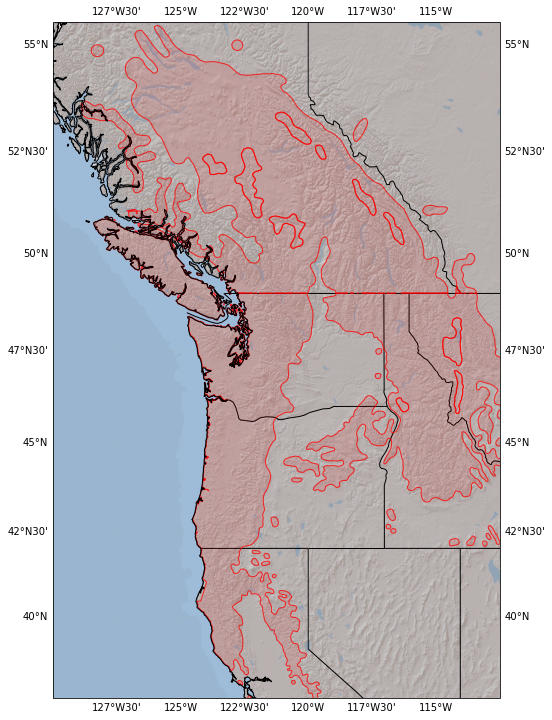

In [6]:
# doug_clipped includes only states and provinances that contain our populations
#    - for making climate maps where color legend reflects range of populations, not range-wide variation
# doug_clipped created in yeaman03:/notebooks/002_doug_fir_gea/10_maps/01_save_legend-friendly_shapefile.ipynb
shapefile = '/data/projects/pool_seq/environemental_data/shapefiles/combined/doug_clipped.shp'
ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, shapefile)])

In [7]:
# clip elevation data to the range of Douglas-fir
# pull offset values directly from the shapefile to ID the pops outside of the shapefile
elevdata,shp = clip_and_retrieve(shapefile, envdata)
elevdata.head()

clipped dataset:


<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    crs      int64 0
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Wed Jun 09 13:49:13 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

There are 13 null values out of 73 rows in elevdata (17.810000000000002%).


lat         lon  crs  Band1
DF_p1  49.787773 -126.639401    0    NaN
DF_p2  50.325470 -122.735252    0    NaN
DF_p3  50.535873 -115.628298    0    NaN
DF_p4  52.032074 -122.337824    0  948.0
DF_p5  49.016294 -119.041506    0    NaN

In [8]:
shp.head()

AREA   PERIMETER  PSEUMENZ_  PSEUMENZ_I  CODE  \
0  97.250401  224.445302          2           2     1   
1   0.078414    1.057782          3           3     1   
2   0.102304    1.211482          4           1     1   
3   1.226948   14.130270          5           4     1   
4   0.002552    0.242197          6           4     1   

                                            geometry  
0  MULTIPOLYGON (((-117.02071 51.61863, -117.0056...  
1  POLYGON ((-122.65261 54.88258, -122.66225 54.8...  
2  POLYGON ((-128.08154 54.76402, -128.09238 54.7...  
3  POLYGON ((-128.51752 53.43138, -128.53613 53.4...  
4  POLYGON ((-128.87219 53.66105, -128.86472 53.6...

In [9]:
# isolate the pops that are outside of the range map by identifying those without elevation data
# create small polygons for each of the pops
out = create_pop_polygons()
out

LONG    LAT                     geometry  \
DF_p1  -126.63  49.78  POINT (-126.63000 49.78000)   
DF_p2  -122.73  50.32  POINT (-122.73000 50.32000)   
DF_p3  -115.62  50.54  POINT (-115.62000 50.54000)   
DF_p5  -119.05  49.02  POINT (-119.05000 49.02000)   
DF_p6  -125.75  52.28  POINT (-125.75000 52.28000)   
DF_p12 -127.83  53.50  POINT (-127.83000 53.50000)   
DF_p17 -122.96  41.53  POINT (-122.96000 41.53000)   
DF_p34 -114.78  49.80  POINT (-114.78000 49.80000)   
DF_p37 -115.55  51.18  POINT (-115.55000 51.18000)   
DF_p40 -124.71  51.72  POINT (-124.71000 51.72000)   
DF_p48 -122.84  54.83  POINT (-122.84000 54.83000)   
DF_p52 -120.67  39.38  POINT (-120.67000 39.38000)   
DF_p53 -119.99  38.39  POINT (-119.99000 38.39000)   

                                                geometry2  
DF_p1   POLYGON ((-126.53000 49.78000, -126.53048 49.7...  
DF_p2   POLYGON ((-122.63000 50.32000, -122.63048 50.3...  
DF_p3   POLYGON ((-115.52000 50.54000, -115.52048 50.5...  
DF_p5   POLYGON ((-118.95000 49.02000, -118.95048 49.0...  
DF_p6   POLYGON ((-125.65000 52.28000, -125.65048 52.2...  
DF_p12  POLYGON ((-127.73000 53.50000, -127.73048 53.4...  
DF_p17  POLYGON ((-122.86000 41.53000, -122.86048 41.5...  
DF_p34  POLYGON ((-114.68000 49.80000, -114.68048 49.7...  
DF_p37  POLYGON ((-115.45000 51.18000, -115.45048 51.1...  
DF_p40  POLYGON ((-124.61000 51.72000, -124.61048 51.7...  
DF_p48  POLYGON ((-122.74000 54.83000, -122.74048 54.8...  
DF_p52  POLYGON ((-120.57000 39.38000, -120.57048 39.3...  
DF_p53  POLYGON ((-119.89000 38.39000, -119.89048 38.3...

In [10]:
# write new polygons to tmp file
tmpshape = '/lu213/brandon.lind/data/testdir/outside.shp'

write_shapefile(tmpshape, out['geometry2'])    

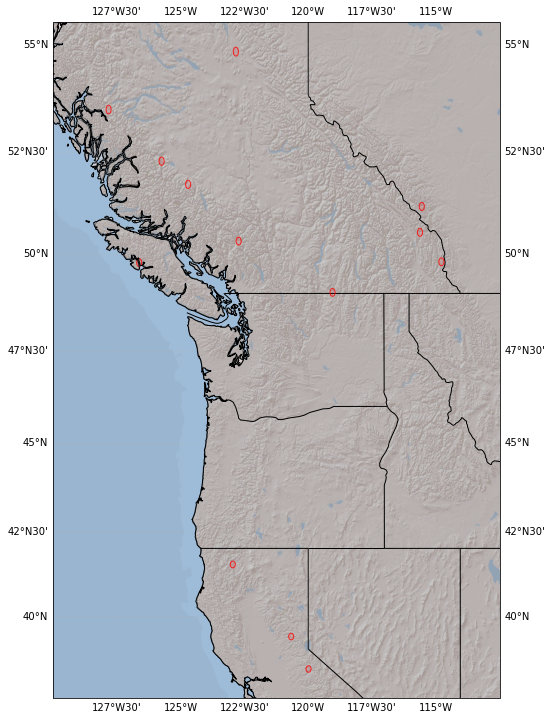

In [11]:
# read in tmp file look at where the new polygons are
ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, tmpshape)])

In [12]:
# combine the species range polygons and the new pop polygons
# dissolve overlapping polygons into single polygons
combined, dissolved = dissolve_polygons()
combined.head()

combined.shape = (147, 1)
dissolved.shape = (205, 1)


geometry
0  POLYGON ((-126.53000 49.78000, -126.53048 49.7...
1  POLYGON ((-122.63000 50.32000, -122.63048 50.3...
2  POLYGON ((-115.52000 50.54000, -115.52048 50.5...
3  POLYGON ((-118.95000 49.02000, -118.95048 49.0...
4  POLYGON ((-125.65000 52.28000, -125.65048 52.2...

In [13]:
dissolved.head()

geometry
0  POLYGON ((-120.53236 34.63070, -120.51730 34.6...
1  POLYGON ((-121.84368 36.47620, -121.83779 36.4...
2  POLYGON ((-119.15192 37.12890, -119.16122 37.1...
3  POLYGON ((-108.37049 45.26705, -108.34872 45.2...
4  POLYGON ((-124.02159 46.28478, -124.02483 46.2...

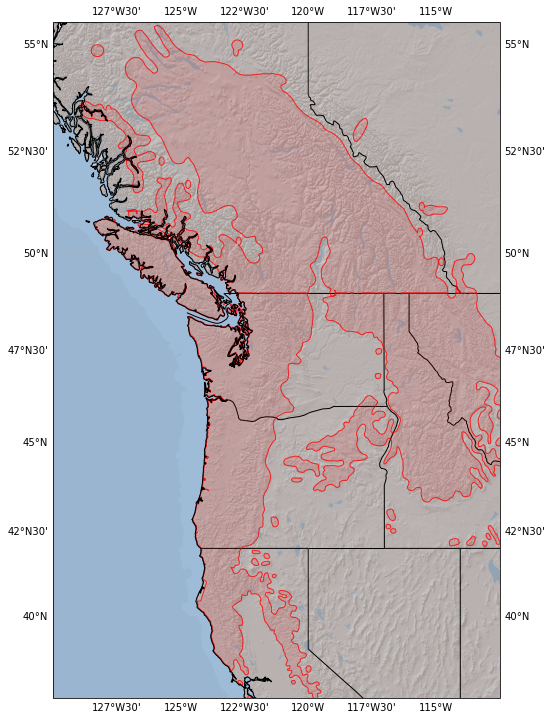

In [14]:
# write to file
unionfile = '/data/projects/pool_seq/environemental_data/shapefiles/combined/df_combined_union_file.shp'

write_shapefile(unionfile, dissolved['geometry'])

ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, unionfile)])

### validate

In [15]:
x,y = clip_and_retrieve(unionfile, envdata)

clipped dataset:


<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    crs      int64 0
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Wed Jun 09 13:49:13 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

There are 0 null values out of 73 rows in elevdata (0.0%).


<a id='coastal'></a>
# update coastal douglas-fir

[top](#home)

In [17]:
# set global vars
extent = [-130, -112.5, 37.5, 55.5]
color = 'lime'
figsize = (8,15)

In [18]:
# read in lat/long of our coastal doug-fir pops
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_coastal-naturalpops_raw_env-19variables_change-p6.txt')
envdata.index = envdata['our_id'].tolist()
envdata.shape

(38, 27)

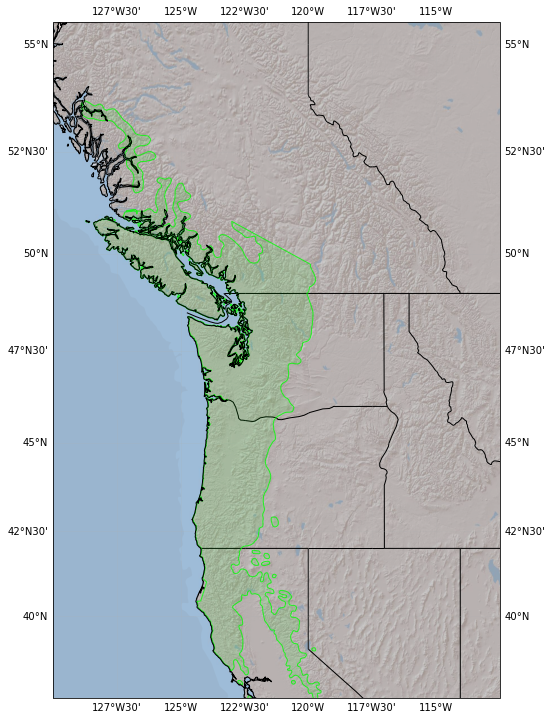

In [19]:
# doug_clipped includes only states and provinances that contain our populations
#    - for making climate maps where color legend reflects range of populations, not range-wide variation
shapefile = '/data/projects/pool_seq/environemental_data/shapefiles/Coastal_DF.shp'
ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, shapefile)])

In [22]:
# clip elevation data to the range of Douglas-fir
# pull elevation values directly from the shapefile to ID the pops outside of the shapefile
elevdata,shp = clip_and_retrieve(shapefile, envdata)
elevdata.head()

clipped dataset:


<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    crs      int64 0
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Fri Jul 02 12:46:30 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

There are 7 null values out of 38 rows in elevdata (18.42%).


lat         lon  crs  Band1
DF_p1   49.787773 -126.639401    0    NaN
DF_p2   50.325470 -122.735252    0    NaN
DF_p6   52.289233 -125.751032    0    NaN
DF_p10  49.998176 -125.330225    0  127.0
DF_p11  48.946160 -123.974293    0  910.0

In [21]:
shp.head()

OBJECTID  FID_New_Sh  Id  FID_Dougla       AREA   PERIMETER  PSEUMENZ_  \
0         1           0   0           0  97.250401  224.445302        2.0   
1         2           0   0           3   1.226948   14.130270        5.0   
2         3           0   0           4   0.002552    0.242197        6.0   
3         4           0   0           5   0.000412    0.077189        7.0   
4         5           0   0           6   0.149967    2.801420        8.0   

   PSEUMENZ_I  CODE  Shape_Leng  Shape_Area  \
0         2.0     1   82.312679   31.582958   
1         4.0     1   14.130270    1.226948   
2         4.0     1    0.242197    0.002552   
3         4.0     1    0.077189    0.000412   
4         4.0     1    2.801420    0.149967   

                                            geometry  
0  POLYGON ((-122.89696 47.30166, -122.90291 47.2...  
1  POLYGON ((-128.45146 53.60525, -128.35209 53.5...  
2  POLYGON ((-128.87164 53.57222, -128.87888 53.5...  
3  POLYGON ((-128.85056 53.59916, -128.85776 53.5...  
4  POLYGON ((-128.77667 53.54694, -128.77029 53.5...

In [23]:
# isolate the pops that are outside of the range map by identifying those without elevation data
# create small polygons for each of the pops
out = create_pop_polygons()
out

LONG    LAT                     geometry  \
DF_p1  -126.63  49.78  POINT (-126.63000 49.78000)   
DF_p2  -122.73  50.32  POINT (-122.73000 50.32000)   
DF_p6  -125.75  52.28  POINT (-125.75000 52.28000)   
DF_p12 -127.83  53.50  POINT (-127.83000 53.50000)   
DF_p17 -122.96  41.53  POINT (-122.96000 41.53000)   
DF_p52 -120.67  39.38  POINT (-120.67000 39.38000)   
DF_p53 -119.99  38.39  POINT (-119.99000 38.39000)   

                                                geometry2  
DF_p1   POLYGON ((-126.53000 49.78000, -126.53048 49.7...  
DF_p2   POLYGON ((-122.63000 50.32000, -122.63048 50.3...  
DF_p6   POLYGON ((-125.65000 52.28000, -125.65048 52.2...  
DF_p12  POLYGON ((-127.73000 53.50000, -127.73048 53.4...  
DF_p17  POLYGON ((-122.86000 41.53000, -122.86048 41.5...  
DF_p52  POLYGON ((-120.57000 39.38000, -120.57048 39.3...  
DF_p53  POLYGON ((-119.89000 38.39000, -119.89048 38.3...

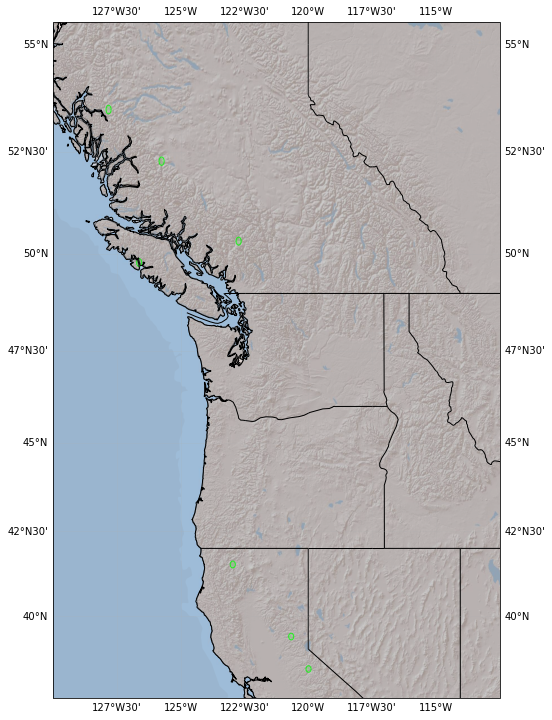

In [23]:
# write new polygons to tmp file
tmpshape = '/lu213/brandon.lind/data/testdir/coast_outside.shp'

write_shapefile(tmpshape, out['geometry2'])    

# read in tmp file look at where the new polygons are
ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, tmpshape)])

In [25]:
# combine the species range polygons and the new pop polygons
# dissolve overlapping polygons into single polygons
combined, dissolved = dissolve_polygons()
combined.head()

combined.shape = (112, 1)
dissolved.shape = (105, 1)


geometry
0  POLYGON ((-126.53000 49.78000, -126.53048 49.7...
1  POLYGON ((-122.63000 50.32000, -122.63048 50.3...
2  POLYGON ((-125.65000 52.28000, -125.65048 52.2...
3  POLYGON ((-127.73000 53.50000, -127.73048 53.4...
4  POLYGON ((-122.86000 41.53000, -122.86048 41.5...

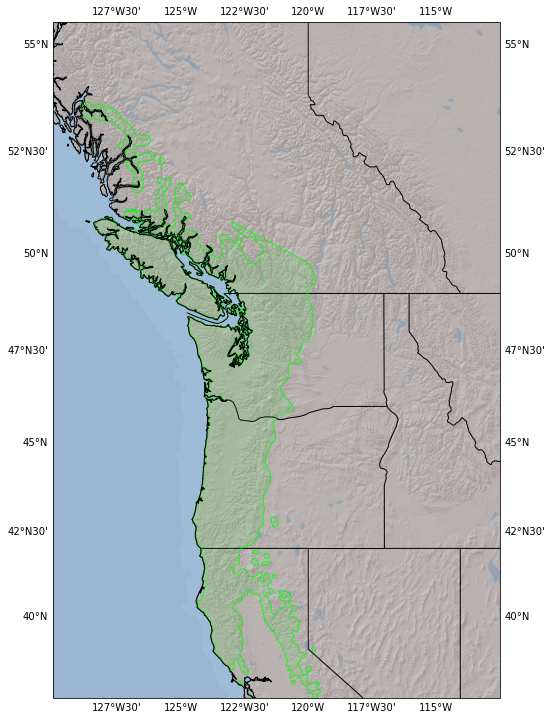

In [26]:
# write to file
# unionfile = '/lu213/brandon.lind/data/testdir/coastal_union_file.shp'
unionfile = '/data/projects/pool_seq/environemental_data/shapefiles/coastal_union_file.shp'

write_shapefile(unionfile, dissolved['geometry'])

ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, unionfile)])

### validate

In [27]:
x,y = clip_and_retrieve(unionfile, envdata)

clipped dataset:


<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    crs      int64 0
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Wed Jun 09 13:49:13 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

There are 0 null values out of 38 rows in elevdata (0.0%).


<a id='interior'></a>
# update interior douglas-fir

[top](#home)

In [28]:
# set global vars
extent = [-130, -112.5, 37.5, 55.5]
color = 'purple'
figsize = (8,15)

In [29]:
# read in lat/long of our interior doug-fir pops
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_interior-naturalpops_raw_env-19variables_change-p6.txt')
envdata.index = envdata['our_id'].tolist()
envdata.shape

(35, 27)

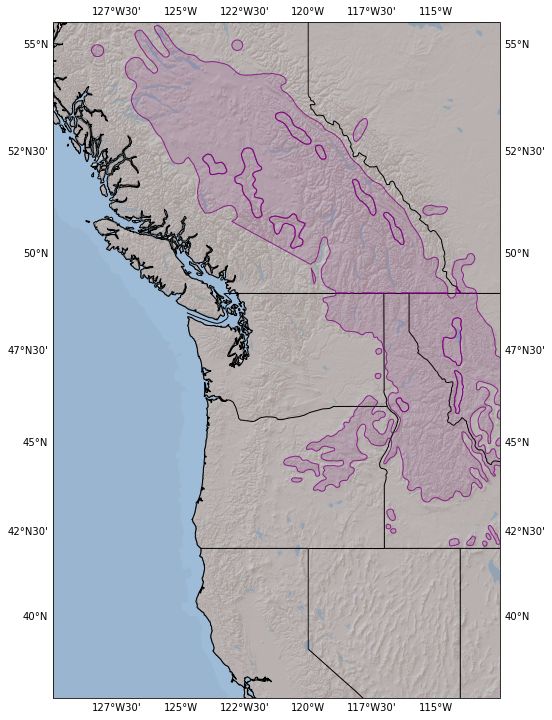

In [30]:
# doug_clipped includes only states and provinances that contain our populations
#    - for making climate maps where color legend reflects range of populations, not range-wide variation
# doug_clipped created in yeaman03:/notebooks/002_doug_fir_gea/10_maps/01_save_legend-friendly_shapefile.ipynb
shapefile = '/data/projects/pool_seq/environemental_data/shapefiles/Interior_DF_clipped.shp'
ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, shapefile)])

In [31]:
# clip elevation data to the range of Douglas-fir
# pull offset values directly from the shapefile to ID the pops outside of the shapefile
elevdata,shp = clip_and_retrieve(shapefile, envdata)
elevdata.head()

clipped dataset:


<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    crs      int64 0
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Wed Jun 09 13:49:13 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

There are 6 null values out of 35 rows in elevdata (17.14%).


lat         lon  crs  Band1
DF_p3  50.535873 -115.628298    0    NaN
DF_p4  52.032074 -122.337824    0  948.0
DF_p5  49.016294 -119.041506    0    NaN
DF_p7  53.972459 -122.127421    0  844.0
DF_p8  54.346509 -124.371722    0  883.0

In [32]:
shp.head()

OBJECTID  FID_New_Sh  Id  FID_Dougla       AREA   PERIMETER  PSEUMENZ_  \
0         1           0   0           0  97.250401  224.445302        2.0   
1         2           0   0           1   0.078414    1.057782        3.0   
2         3           0   0           2   0.102304    1.211482        4.0   
3         4           0   0           7   0.349824    3.326692        9.0   
4         5           0   0           8   0.169970    1.663820       10.0   

   PSEUMENZ_I  CODE  Shape_Leng  Shape_Area  \
0         2.0     1  149.543107   65.688572   
1         3.0     1    1.057782    0.078414   
2         1.0     1    1.202778    0.100191   
3         5.0     0    3.326692    0.349824   
4         8.0     1    1.663820    0.169970   

                                            geometry  
0  MULTIPOLYGON (((-124.45756 54.74490, -124.3366...  
1  POLYGON ((-122.77442 54.85753, -122.78241 54.8...  
2  POLYGON ((-128.25688 54.71840, -128.26484 54.7...  
3  POLYGON ((-119.98493 52.68611, -120.06821 52.6...  
4  POLYGON ((-118.03018 52.78633, -118.10618 52.7...

In [33]:
# isolate the pops that are outside of the range map by identifying those without elevation data
# create small polygons for each of the pops
out = create_pop_polygons()
out

LONG    LAT                     geometry  \
DF_p3  -115.62  50.54  POINT (-115.62000 50.54000)   
DF_p5  -119.05  49.02  POINT (-119.05000 49.02000)   
DF_p34 -114.78  49.80  POINT (-114.78000 49.80000)   
DF_p37 -115.55  51.18  POINT (-115.55000 51.18000)   
DF_p40 -124.71  51.72  POINT (-124.71000 51.72000)   
DF_p48 -122.84  54.83  POINT (-122.84000 54.83000)   

                                                geometry2  
DF_p3   POLYGON ((-115.52000 50.54000, -115.52048 50.5...  
DF_p5   POLYGON ((-118.95000 49.02000, -118.95048 49.0...  
DF_p34  POLYGON ((-114.68000 49.80000, -114.68048 49.7...  
DF_p37  POLYGON ((-115.45000 51.18000, -115.45048 51.1...  
DF_p40  POLYGON ((-124.61000 51.72000, -124.61048 51.7...  
DF_p48  POLYGON ((-122.74000 54.83000, -122.74048 54.8...

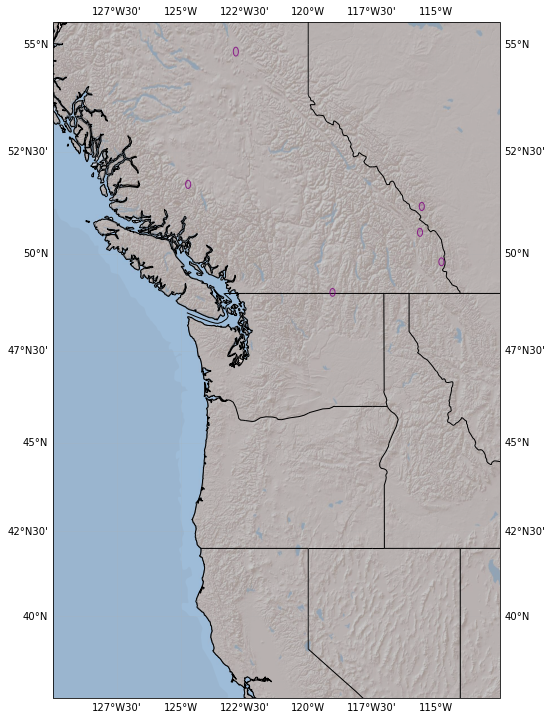

In [34]:
# write new polygons to tmp file
tmpshape = '/lu213/brandon.lind/data/testdir/interior_outside.shp'

write_shapefile(tmpshape, out['geometry2'])    

# read in tmp file look at where the new polygons are
ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, tmpshape)])

In [35]:
# combine the species range polygons and the new pop polygons
# dissolve overlapping polygons into single polygons
combined, dissolved = dissolve_polygons()
combined.head()

combined.shape = (47, 1)
dissolved.shape = (36, 1)


geometry
0  POLYGON ((-115.52000 50.54000, -115.52048 50.5...
1  POLYGON ((-118.95000 49.02000, -118.95048 49.0...
2  POLYGON ((-114.68000 49.80000, -114.68048 49.7...
3  POLYGON ((-115.45000 51.18000, -115.45048 51.1...
4  POLYGON ((-124.61000 51.72000, -124.61048 51.7...

In [36]:
dissolved.head()

geometry
0  POLYGON ((-116.60921 42.82521, -116.66757 42.8...
1  POLYGON ((-111.04698 42.34966, -111.04940 42.3...
2  POLYGON ((-116.61887 42.44608, -116.67972 42.4...
3  POLYGON ((-114.38782 42.07255, -114.42170 42.0...
4  POLYGON ((-111.73589 41.99871, -111.73388 42.0...

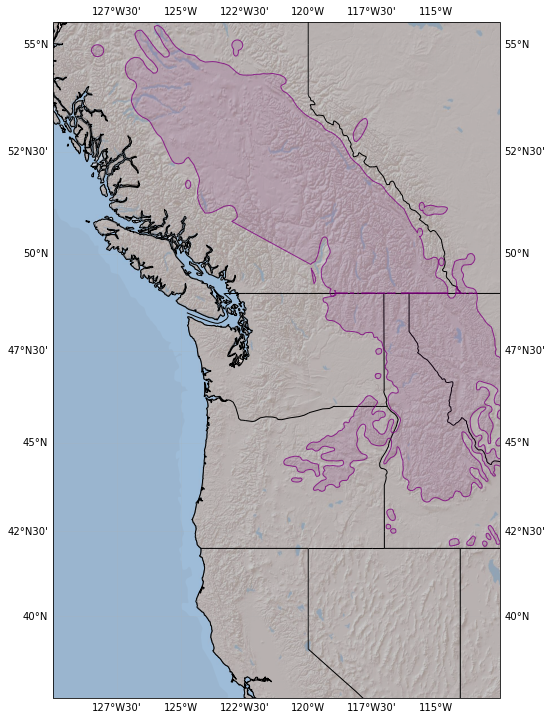

In [37]:
# write to file
# unionfile = '/lu213/brandon.lind/data/testdir/coastal_union_file.shp'
unionfile = '/data/projects/pool_seq/environemental_data/shapefiles/interior_union_file.shp'

write_shapefile(unionfile, dissolved['geometry'])

ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, unionfile)])

### validate 

In [38]:
x,y = clip_and_retrieve(unionfile, envdata)

clipped dataset:


<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    crs      int64 0
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Wed Jun 09 13:49:13 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

There are 0 null values out of 35 rows in elevdata (0.0%).


<a id='jack'></a>
# update jack pine

[top](#home)

In [39]:
# set global vars
extent = [-119.5, -58, 41, 60]
color = 'green'
figsize = (15,10)

In [40]:
# read in lat/long of our jack pops
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_raw_env-19variables.txt')
envdata.index = envdata['our_id'].tolist()
envdata.shape

(39, 26)

In [41]:
envdata.head()

id1  id2   our_id      LAT      LONG  Elevation   AHM  CMD   DD5  \
JP_p98   9150251   38   JP_p98  54.3333 -106.6333        537  21.2  181  1273   
JP_p73      3273   22   JP_p73  44.4200  -84.6800        359  22.0  241  1956   
JP_p97   8060006   37   JP_p97  56.1167 -116.9167        636  23.5  242  1188   
JP_p60      3260   17   JP_p60  46.7200  -84.3900        203  16.5  135  1557   
JP_p100  9040116   40  JP_p100  55.7667  -97.8167        205  13.3  130  1003   

         DD_0   EMT   EXT  Eref  FFP  MAP  MAT  MCMT  MSP  MWMT  NFFD  PAS  \
JP_p98   2217 -46.0  34.7   534  103  461 -0.2 -20.1  305  16.6   149  129   
JP_p73    835 -34.1  36.6   745  131  732  6.1  -8.0  395  19.8   163  140   
JP_p97   2009 -44.3  34.8   556   90  432  0.2 -19.8  272  15.4   138  133   
JP_p60   1116 -36.8  34.3   599  123  848  4.0 -10.7  397  17.6   156  265   
JP_p100  2956 -49.7  35.2   448   82  506 -3.3 -24.9  315  15.7   106  191   

          SHM    TD  bFFP  eFFP group_color  
JP_p98   54.4  36.7   148   251       green  
JP_p73   50.0  27.8   141   271        blue  
JP_p97   56.5  35.1   151   241       green  
JP_p60   44.2  28.3   147   271        blue  
JP_p100  49.9  40.6   163   245       green

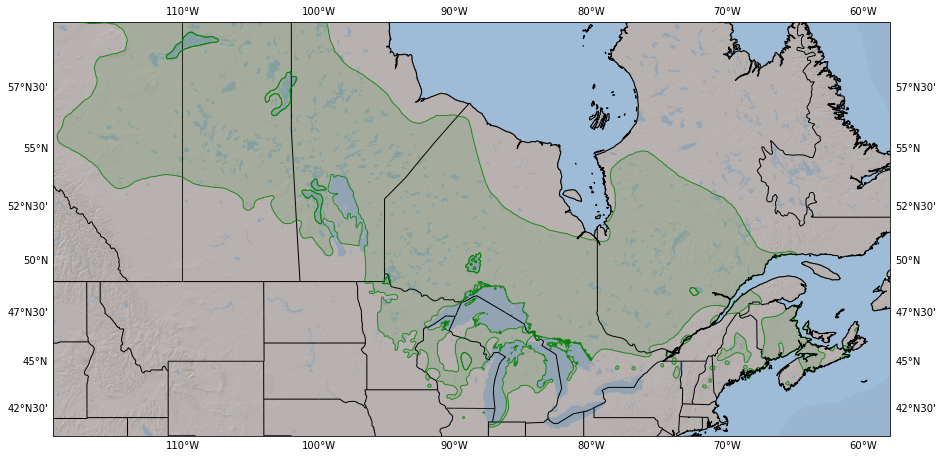

In [42]:
shapefile = '/data/projects/pool_seq/environemental_data/shapefiles/jackpine.shp'
ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, shapefile)])

In [43]:
# clip elevation data to the range of jack pine
# pull offset values directly from the shapefile to ID the pops outside of the shapefile
elevdata,shp = clip_and_retrieve(shapefile, envdata)
elevdata.head()

clipped dataset:


<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    crs      int64 0
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Wed Jun 09 13:49:13 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

There are 6 null values out of 39 rows in elevdata (15.379999999999999%).


lat         lon  crs  Band1
JP_p98   54.323131 -106.627715    0  536.0
JP_p73   44.410801  -84.675644    0  365.0
JP_p97   56.123248 -116.914096    0  625.0
JP_p60   46.725237  -84.395107    0  189.0
JP_p100  55.772576  -97.814158    0  208.0

In [44]:
shp.head()

AREA   PERIMETER  PINUBANK_  PINUBANK_I  CODE  \
0  413.682100  303.439800          2           1     1   
1    5.413914   27.910060          3           2     0   
2    1.288178    8.214408          4           3     0   
3    1.504920    8.263519          5           4     0   
4    0.261701    2.632763          6           5     0   

                                            geometry  
0  POLYGON ((-127.22823 65.18945, -127.20777 65.1...  
1  POLYGON ((-115.92808 63.05474, -115.85393 63.0...  
2  POLYGON ((-111.14291 58.74481, -111.09769 58.7...  
3  POLYGON ((-102.04394 58.11267, -102.02443 58.0...  
4  POLYGON ((-99.47186 53.28780, -99.47929 53.271...

In [45]:
# isolate the pops that are outside of the range map by identifying those without elevation data
# create small polygons for each of the pops
out = create_pop_polygons(buffer_size=0.2)
out

LONG      LAT                    geometry  \
JP_p14 -66.6966  47.3793  POINT (-66.69660 47.37930)   
JP_p99 -99.3333  49.7000  POINT (-99.33330 49.70000)   
JP_p39 -77.8833  44.6500  POINT (-77.88330 44.65000)   
JP_p27 -72.5833  46.4166  POINT (-72.58330 46.41660)   
JP_p29 -70.1531  47.6250  POINT (-70.15310 47.62500)   
JP_p4  -60.3500  46.7500  POINT (-60.35000 46.75000)   

                                                geometry2  
JP_p14  POLYGON ((-66.49660 47.37930, -66.49756 47.359...  
JP_p99  POLYGON ((-99.13330 49.70000, -99.13426 49.680...  
JP_p39  POLYGON ((-77.68330 44.65000, -77.68426 44.630...  
JP_p27  POLYGON ((-72.38330 46.41660, -72.38426 46.397...  
JP_p29  POLYGON ((-69.95310 47.62500, -69.95406 47.605...  
JP_p4   POLYGON ((-60.15000 46.75000, -60.15096 46.730...

In [46]:
# write new polygons to tmp file
tmpshape = '/lu213/brandon.lind/data/testdir/jp_outside.shp'

write_shapefile(tmpshape, out['geometry2'])    

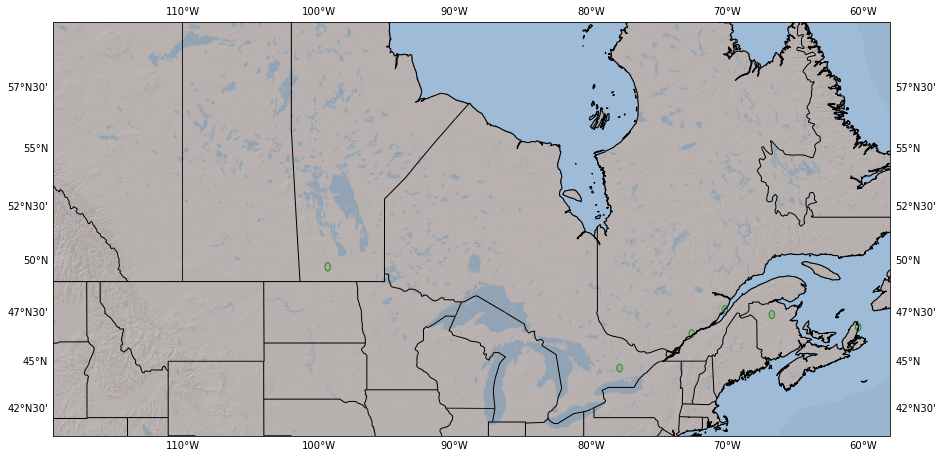

In [47]:
# read in tmp file look at where the new polygons are
ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, tmpshape)])

In [48]:
# combine the species range polygons and the new pop polygons
# dissolve overlapping polygons into single polygons
combined, dissolved = dissolve_polygons()
combined.head()

combined.shape = (401, 1)
dissolved.shape = (376, 1)


geometry
0  POLYGON ((-66.49660 47.37930, -66.49756 47.359...
1  POLYGON ((-99.13330 49.70000, -99.13426 49.680...
2  POLYGON ((-77.68330 44.65000, -77.68426 44.630...
3  POLYGON ((-72.38330 46.41660, -72.38426 46.397...
4  POLYGON ((-69.95310 47.62500, -69.95406 47.605...

In [49]:
dissolved.head()

geometry
0  POLYGON ((-89.31502 41.95777, -89.31733 41.956...
1  POLYGON ((-87.84827 42.23732, -87.85073 42.236...
2  POLYGON ((-60.41165 46.55990, -60.42149 46.547...
3  POLYGON ((-61.72325 47.48580, -61.73568 47.479...
4  POLYGON ((-61.94659 47.32000, -61.95113 47.320...

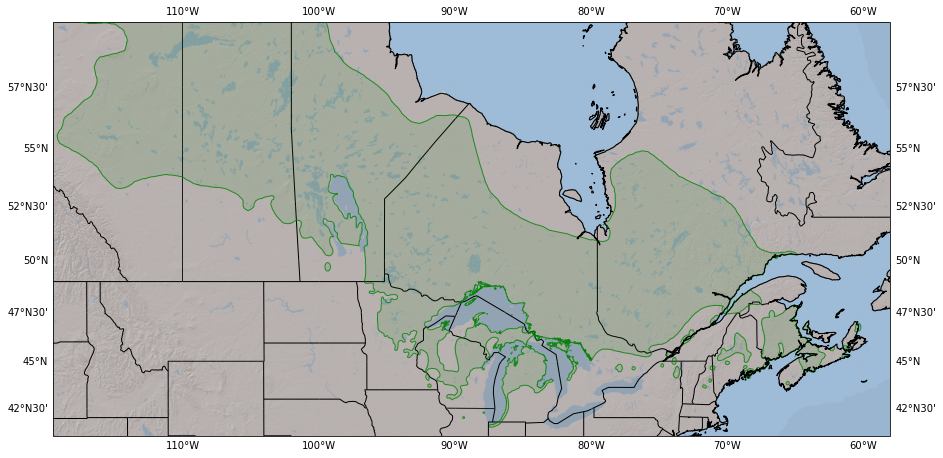

In [50]:
# write to file
unionfile = '/data/projects/pool_seq/environemental_data/shapefiles/jp_union_file.shp'

write_shapefile(unionfile, dissolved['geometry'])

ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, unionfile)])

### validate

In [51]:
x,y = clip_and_retrieve(unionfile, envdata)

clipped dataset:


<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    crs      int64 0
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Wed Jun 09 13:49:13 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

There are 0 null values out of 39 rows in elevdata (0.0%).


<a id='western'></a>
# update Western larch

[top](#home)

In [52]:
# set global vars
extent = [-122.3, -112.55, 43.26, 51.6]
color = 'green'
figsize = (15,10)

In [53]:
# read in lat/long of our WL pops
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/wl_std_env-19variables_45pops.txt')
envdata.index = envdata['our_id'].tolist()
envdata.shape

(45, 31)

In [54]:
envdata.head()

id1   our_id id2  Latitude  Longitude  Elevation       MAT      MWMT  \
WL_p272  272  WL_p272  NI     48.28    -116.92      701.0  1.520220  1.442254   
WL_p281  281  WL_p281  WA     48.75    -118.00      610.0  1.719086  1.962506   
WL_p285  285  WL_p285  WA     48.83    -118.83     1311.0 -0.269574 -0.118502   
WL_p287  287  WL_p287  WM     47.35    -115.43     1219.0  0.327024  0.336719   
WL_p291  291  WL_p291  CM     46.93    -113.72     1244.0  0.260735  0.661876   

             MCMT        TD       MAP       MSP       AHM       SHM      DD_0  \
WL_p272  1.068181  0.099901 -0.061316 -0.549753  0.170898  0.590189 -1.270286   
WL_p281  0.758729  1.053501 -0.776225 -0.785212  1.301455  1.004087 -1.119537   
WL_p285 -0.272776  0.236130 -1.185892 -0.706725  1.419770  0.299734  0.402536   
WL_p287  0.500853 -0.376899  0.500972  0.046743 -0.631009 -0.190409 -0.497092   
WL_p291 -0.118050  0.849158 -0.868601 -0.518358  0.920221  0.350563 -0.069161   

              DD5   DD_18   DD18      NFFD      bFFP      eFFP       FFP  \
WL_p272  1.503476  4008.0  127.0  1.194323 -1.057869  0.371450  0.834090   
WL_p281  2.027029  3938.0  172.0  1.496987 -1.464047  1.167415  1.429142   
WL_p285 -0.144612  4893.0   50.0  0.156617 -0.570455  0.990534  0.879863   
WL_p287  0.279392  4595.0   60.0 -0.059572  0.404373 -0.070752 -0.264468   
WL_p291  0.493238  4649.0   73.0 -0.405474  0.241902 -0.601396 -0.447560   

              PAS       EMT       EXT      Eref       CMD   MAR    RH  \
WL_p272 -0.673825  1.261301  1.476122  1.558195  1.122037  12.9  58.0   
WL_p281 -1.020206  1.041306  1.680194  1.546900  1.440262  11.9  59.0   
WL_p285 -0.888581 -0.498654 -0.360528 -0.802440  0.070127  12.9  63.0   
WL_p287  0.296040  0.546319  0.761870  0.327050  0.282277  13.8  59.0   
WL_p291 -0.694608 -0.471155  1.016960  0.643308  1.060160  14.2  54.0   

        group_color_k5 group_color_k2  
WL_p272        magenta          green  
WL_p281            red           blue  
WL_p285            red           blue  
WL_p287        magenta          green  
WL_p291        magenta          green

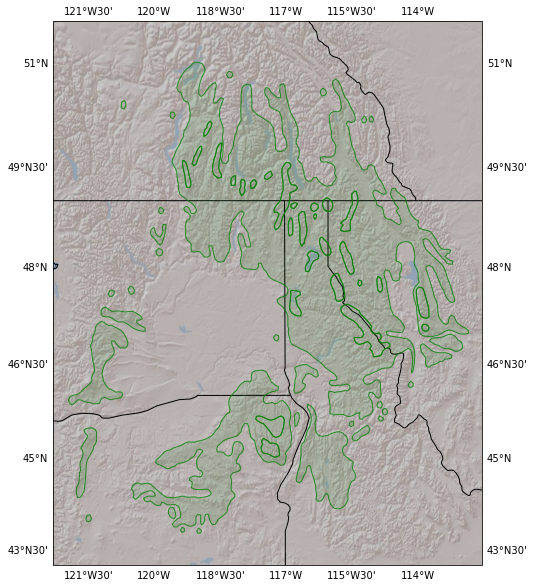

In [55]:
shapefile = '/data/projects/pool_seq/environemental_data/shapefiles/larch_gis/lariocci.shp'
ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, shapefile)])

In [56]:
envdata.head()

id1   our_id id2  Latitude  Longitude  Elevation       MAT      MWMT  \
WL_p272  272  WL_p272  NI     48.28    -116.92      701.0  1.520220  1.442254   
WL_p281  281  WL_p281  WA     48.75    -118.00      610.0  1.719086  1.962506   
WL_p285  285  WL_p285  WA     48.83    -118.83     1311.0 -0.269574 -0.118502   
WL_p287  287  WL_p287  WM     47.35    -115.43     1219.0  0.327024  0.336719   
WL_p291  291  WL_p291  CM     46.93    -113.72     1244.0  0.260735  0.661876   

             MCMT        TD       MAP       MSP       AHM       SHM      DD_0  \
WL_p272  1.068181  0.099901 -0.061316 -0.549753  0.170898  0.590189 -1.270286   
WL_p281  0.758729  1.053501 -0.776225 -0.785212  1.301455  1.004087 -1.119537   
WL_p285 -0.272776  0.236130 -1.185892 -0.706725  1.419770  0.299734  0.402536   
WL_p287  0.500853 -0.376899  0.500972  0.046743 -0.631009 -0.190409 -0.497092   
WL_p291 -0.118050  0.849158 -0.868601 -0.518358  0.920221  0.350563 -0.069161   

              DD5   DD_18   DD18      NFFD      bFFP      eFFP       FFP  \
WL_p272  1.503476  4008.0  127.0  1.194323 -1.057869  0.371450  0.834090   
WL_p281  2.027029  3938.0  172.0  1.496987 -1.464047  1.167415  1.429142   
WL_p285 -0.144612  4893.0   50.0  0.156617 -0.570455  0.990534  0.879863   
WL_p287  0.279392  4595.0   60.0 -0.059572  0.404373 -0.070752 -0.264468   
WL_p291  0.493238  4649.0   73.0 -0.405474  0.241902 -0.601396 -0.447560   

              PAS       EMT       EXT      Eref       CMD   MAR    RH  \
WL_p272 -0.673825  1.261301  1.476122  1.558195  1.122037  12.9  58.0   
WL_p281 -1.020206  1.041306  1.680194  1.546900  1.440262  11.9  59.0   
WL_p285 -0.888581 -0.498654 -0.360528 -0.802440  0.070127  12.9  63.0   
WL_p287  0.296040  0.546319  0.761870  0.327050  0.282277  13.8  59.0   
WL_p291 -0.694608 -0.471155  1.016960  0.643308  1.060160  14.2  54.0   

        group_color_k5 group_color_k2  
WL_p272        magenta          green  
WL_p281            red           blue  
WL_p285            red           blue  
WL_p287        magenta          green  
WL_p291        magenta          green

In [57]:
# clip elevation data to the range of western larch
# pull offset values directly from the shapefile to ID the pops outside of the shapefile
elevdata,shp = clip_and_retrieve(shapefile, envdata, latcol='Latitude', loncol='Longitude')
elevdata.head()

clipped dataset:


<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    crs      int64 0
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Wed Jun 09 13:49:13 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

There are 6 null values out of 45 rows in elevdata (13.33%).


lat         lon  crs   Band1
WL_p272  48.291572 -116.914096    0   925.0
WL_p281  48.759135 -117.989490    0   814.0
WL_p285  48.829269 -118.831103    0  1650.0
WL_p287  47.356446 -115.441273    0  1291.0
WL_p291  46.935640 -113.711291    0  1172.0

In [58]:
shp.head()

AREA  PERIMETER  LARIOCCI_  LARIOCCI_I  CODE  \
0  13.544831  72.848955          2           1     1   
1   0.009242   0.366447          3           2     1   
2   0.011057   0.390711          4           5     1   
3   0.009829   0.369430          5           3     1   
4   0.008081   0.337905          6           4     1   

                                            geometry  
0  POLYGON ((-117.47484 50.54311, -117.48257 50.5...  
1  POLYGON ((-118.29111 50.88407, -118.23871 50.8...  
2  POLYGON ((-116.16008 50.64377, -116.10307 50.6...  
3  POLYGON ((-120.68656 50.46318, -120.66850 50.4...  
4  POLYGON ((-119.60427 50.29753, -119.54553 50.2...

In [59]:
# isolate the pops that are outside of the range map by identifying those without elevation data
# create small polygons for each of the pops
out = create_pop_polygons(loncol='Longitude', latcol='Latitude')
out

Longitude  Latitude                     geometry  \
WL_p335    -114.13    47.080  POINT (-114.13000 47.08000)   
WL_p350    -113.55    48.170  POINT (-113.55000 48.17000)   
WL_p382    -121.32    45.090  POINT (-121.32000 45.09000)   
WL_p385    -120.27    44.260  POINT (-120.27000 44.26000)   
WL_p403    -115.95    49.420  POINT (-115.95000 49.42000)   
BWL_p10    -120.90    50.275  POINT (-120.90000 50.27500)   

                                                 geometry2  
WL_p335  POLYGON ((-114.03000 47.08000, -114.03048 47.0...  
WL_p350  POLYGON ((-113.45000 48.17000, -113.45048 48.1...  
WL_p382  POLYGON ((-121.22000 45.09000, -121.22048 45.0...  
WL_p385  POLYGON ((-120.17000 44.26000, -120.17048 44.2...  
WL_p403  POLYGON ((-115.85000 49.42000, -115.85048 49.4...  
BWL_p10  POLYGON ((-120.80000 50.27500, -120.80048 50.2...

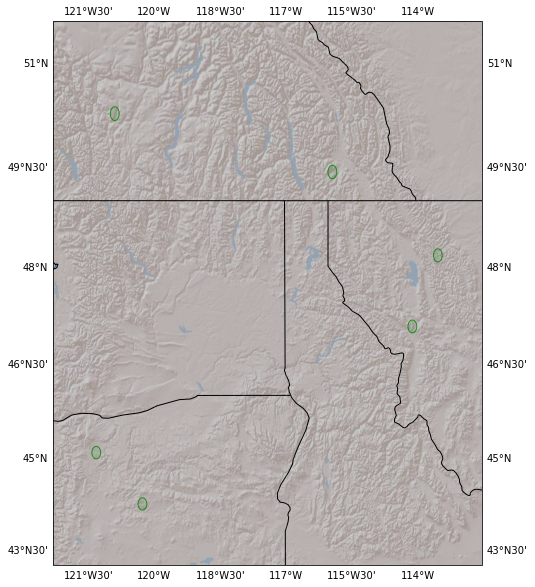

In [60]:
# write new polygons to tmp file
tmpshape = '/lu213/brandon.lind/data/testdir/wl_outside.shp'

write_shapefile(tmpshape, out['geometry2'])

# read in tmp file look at where the new polygons are
ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, tmpshape)])

In [61]:
# combine the species range polygons and the new pop polygons
# dissolve overlapping polygons into single polygons
combined, dissolved = dissolve_polygons()
combined.head()

combined.shape = (66, 1)
dissolved.shape = (34, 1)


geometry
0  POLYGON ((-114.03000 47.08000, -114.03048 47.0...
1  POLYGON ((-113.45000 48.17000, -113.45048 48.1...
2  POLYGON ((-121.22000 45.09000, -121.22048 45.0...
3  POLYGON ((-120.17000 44.26000, -120.17048 44.2...
4  POLYGON ((-115.85000 49.42000, -115.85048 49.4...

In [62]:
dissolved.head()

geometry
0  POLYGON ((-118.99046 43.86636, -118.92830 43.8...
1  POLYGON ((-119.36472 43.87561, -119.32161 43.8...
2  POLYGON ((-121.46768 44.08407, -121.45216 44.0...
3  POLYGON ((-121.38513 45.47163, -121.34325 45.4...
4  POLYGON ((-119.62613 44.20584, -119.57140 44.2...

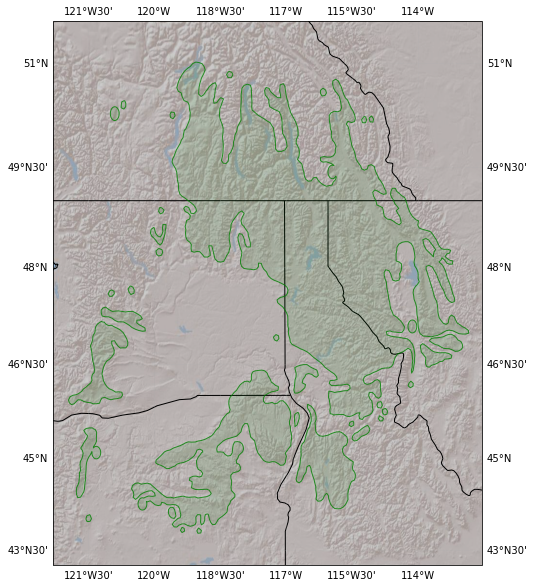

In [63]:
# write to file
unionfile = '/data/projects/pool_seq/environemental_data/shapefiles/wl_union_file.shp'

write_shapefile(unionfile, dissolved['geometry'])

ax = basemap(extent=extent, figsize=figsize, shapefiles=[(color, unionfile)])

### validate 

In [64]:
x,y = clip_and_retrieve(unionfile, envdata, latcol='Latitude', loncol='Longitude')

clipped dataset:


<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    crs      int64 0
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Wed Jun 09 13:49:13 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

There are 0 null values out of 45 rows in elevdata (0.0%).


<a id='bottom'></a>
# notebook bottom

[top](#home)